In [1]:
#Setting up paths for data
data_root = "/home/jovyan/nnunet2-mig-7g-80gb-datavol-1/data/Brain-Tumor-Classification" 

tr_base  = data_root+"/Training"
te_base  = data_root+"/Testing"

In [2]:
#Setting up Transforms 
from pathlib import Path
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler # remember subset when you divide into training and validation
from torchvision import datasets, transforms, utils, models # add models when you import pretrained models for transfer learning
import os
import torch
import numpy as np

IMG_SIZE = 512

def zscore(x):  # MRI-friendly
    return (x - x.mean()) / (x.std() + 1e-8)

train_tf = transforms.Compose([
    transforms.Lambda(lambda im: im.convert('L')),                 # use 'RGB' if truly 3-ch
    transforms.Grayscale(num_output_channels=3), 
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.02,0.02), scale=(0.95,1.05)),
    transforms.RandomApply([transforms.GaussianBlur(3, (0.1, 1.0))], p=0.2),
    transforms.ColorJitter(brightness=0.10, contrast=0.10),
    transforms.ToTensor(),
    #transforms.Lambda(zscore),
])

eval_tf = transforms.Compose([
    transforms.Lambda(lambda im: im.convert('L')),
    transforms.Grayscale(num_output_channels=3), 
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    transforms.ToTensor(),
    #transforms.Lambda(zscore),
])

In [3]:
trainset=datasets.ImageFolder(tr_base, transform=train_tf)
valset = datasets.ImageFolder(tr_base, transform=eval_tf)
testset=datasets.ImageFolder(te_base, transform=eval_tf)


print(testset.classes)
print(trainset.classes)
print(valset.classes)

val_fraction=0.2

idxs = list(range(len(valset)))
rng = np.random.default_rng(42)
rng.shuffle(idxs)

n_val = int(len(idxs) * val_fraction)
val_idx = idxs[:n_val]
train_idx = idxs[n_val:]

trainset = Subset(trainset, train_idx)
valset   = Subset(valset,   val_idx)

class_names = datasets.ImageFolder(tr_base).classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [4]:
def get_targets_from_dataset(ds) -> np.ndarray:
    """Return class indices for ImageFolder or Subset(ImageFolder)."""
    if isinstance(ds, Subset):
        base, idxs = ds.dataset, ds.indices
        if hasattr(base, "targets"):
            return np.asarray(base.targets, dtype=int)[idxs]
        return np.asarray([base.samples[i][1] for i in idxs], dtype=int)
    # ImageFolder
    if hasattr(ds, "targets"):
        return np.asarray(ds.targets, dtype=int)
    return np.asarray([y for _, y in ds.samples], dtype=int)

In [5]:

# assume you already created trainset (ImageFolder or Subset(ImageFolder))
targets = get_targets_from_dataset(trainset)              # shape [N]
num_classes = int(targets.max() + 1)

# inverse-frequency class weights (simple & effective)
class_counts  = np.bincount(targets, minlength=num_classes).astype(float)
class_weights = 1.0 / np.maximum(class_counts, 1.0)      # avoid div/0
sample_weights = class_weights[targets]                   # per-sample weight

sampler = WeightedRandomSampler(
    weights=torch.as_tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),   # one epoch ~= dataset size
    replacement=True                   # allows oversampling of minority class
)

BATCH = 4
WORKERS = 4


train_loader = DataLoader(
    trainset,
    batch_size=BATCH,
    shuffle=False,
    sampler=sampler,
    num_workers=WORKERS,
    pin_memory=True,
    drop_last=True,                    # optional: keeps batch size stable
)

# validation/test loaders stay standard (no sampler)
val_loader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=WORKERS, pin_memory=True)

In [6]:
import torch.nn as nn
from torchvision import models

def build_model(n_classes, freeze_backbone=False):
    """
    Build a Swin Transformer Base model pretrained on ImageNet-1K,
    replace classification head for custom number of classes,
    and optionally freeze backbone layers.
    """
    # 1️⃣ Load pretrained Swin Transformer Base
    model = models.swin_b(weights=models.Swin_B_Weights.IMAGENET1K_V1)

    # 2️⃣ Replace classifier head
    in_feats = model.head.in_features
    model.head = nn.Linear(in_feats, n_classes)

    # 3️⃣ Optionally freeze transformer backbone
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.head.parameters():
            param.requires_grad = True

    return model

model = build_model(n_classes=4, freeze_backbone=False)
print(model)

# Verify output
import torch
x = torch.randn(2, 3, 512, 512)
out = model(x)
print(out.shape)  # → [2, 4]


Downloading: "https://download.pytorch.org/models/swin_b-68c6b09e.pth" to /home/jovyan/.cache/torch/hub/checkpoints/swin_b-68c6b09e.pth
100%|██████████| 335M/335M [00:08<00:00, 39.9MB/s] 


SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=512, out_features=128, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock

In [7]:
# ----------------------------
# 3) Training utilities
# ----------------------------
class EarlyStopper:
    def __init__(self, patience=8, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.count = 0

    def step(self, metric):
        if self.best is None or metric > self.best + self.min_delta:
            self.best = metric
            self.count = 0
            return False  # do not stop

In [8]:
import contextlib
import torch
import torch.nn.functional as F

def epoch_run(model, loader, criterion, device, train: bool, use_amp: bool,
              optimizer=None, scaler=None):
    assert (train and optimizer is not None and scaler is not None) or (not train)

    model.train() if train else model.eval()

    total = 0
    running_loss = 0.0
    correct = 0

    # no graph during evaluation
    cm = contextlib.nullcontext() if train else torch.no_grad()

    with cm:
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            with torch.amp.autocast('cuda', enabled=(use_amp and device.type == 'cuda')):
                logits = model(xb)
                loss = criterion(logits, yb)

            if train:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            running_loss += loss.detach().float().item() * xb.size(0)
            pred = logits.argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)

    return running_loss / total, correct / total


In [9]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def to_device(batch, device):
    x, y = batch
    return x.to(device, non_blocking=True), y.to(device, non_blocking=True)

Device: cuda
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Train uses sampler: WeightedRandomSampler
Val uses sampler:   SequentialSampler
Test uses sampler:  SequentialSampler
Epoch 01/500 | train_loss=1.2869 acc=0.4138 | val_loss=1.1818 acc=0.5200
Epoch 02/500 | train_loss=1.0246 acc=0.6157 | val_loss=0.9285 acc=0.6643
Epoch 03/500 | train_loss=0.7820 acc=0.7451 | val_loss=0.7306 acc=0.7443
Epoch 04/500 | train_loss=0.6924 acc=0.7755 | val_loss=0.5849 acc=0.8070
Epoch 05/500 | train_loss=0.5594 acc=0.8450 | val_loss=0.6940 acc=0.8017
Epoch 06/500 | train_loss=0.5374 acc=0.8615 | val_loss=0.5862 acc=0.8383
Epoch 07/500 | train_loss=0.5349 acc=0.8611 | val_loss=0.4250 acc=0.9096
Epoch 08/500 | train_loss=0.4841 acc=0.8828 | val_loss=0.4061 acc=0.8991
Epoch 09/500 | train_loss=0.3901 acc=0.9253 | val_loss=0.3777 acc=0.9426
Epoch 10/500 | train_loss=0.3778 acc=0.9292 | val_loss=0.3499 acc=0.9357
Epoch 11/500 | train_loss=0.3412 acc=0.9444 | val_loss=0.3200 

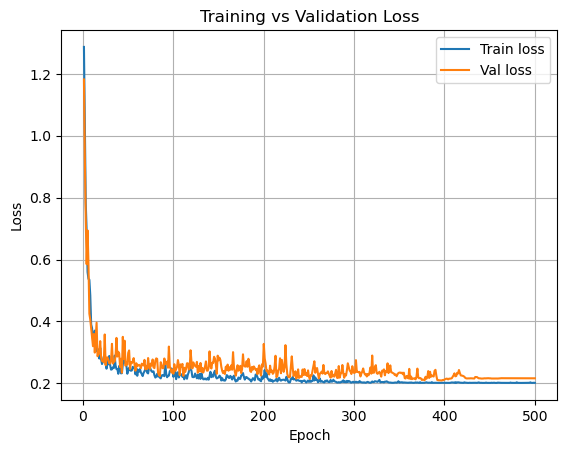

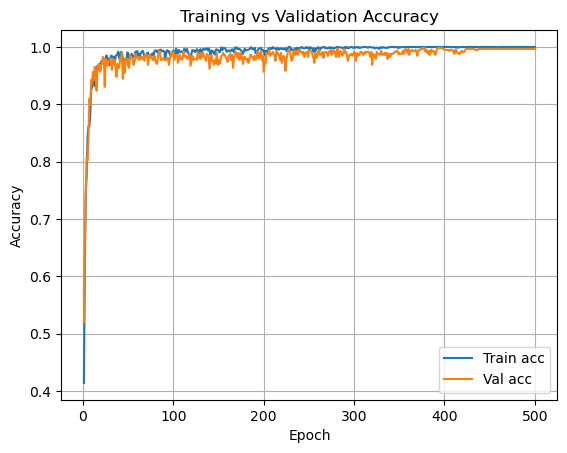

/tmp/ipykernel_264763/4174903574.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location=device)



Test classification report:
                  precision    recall  f1-score   support

    glioma_tumor     1.0000    0.3300    0.4962       100
meningioma_tumor     0.7055    1.0000    0.8273       115
        no_tumor     0.8012    1.0000    0.8897       129
 pituitary_tumor     0.9672    0.7973    0.8741        74

        accuracy                         0.8038       418
       macro avg     0.8685    0.7818    0.7718       418
    weighted avg     0.8518    0.8038    0.7756       418


Confusion matrix:
[[ 33  39  26   2]
 [  0 115   0   0]
 [  0   0 129   0]
 [  0   9   6  59]]


In [10]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from torch import amp
import json

seed=2025
set_seed(seed)
device = get_device()
print("Device:", device)

DATA_ROOT = data_root 
BATCH = 32
EPOCHS = 500
LR = 3e-4
FREEZE_BACKBONE = False  # set True to train only the last layer first

#trainset, valset, testset, class_names = build_datasets(DATA_ROOT, img_size=224, val_fraction=0.15)
print("Classes:", class_names)

scaler = amp.GradScaler('cuda', enabled=(device.type=='cuda'))

train_loader = DataLoader(trainset,batch_size=BATCH,sampler=sampler,num_workers=WORKERS,pin_memory=True)                    # optional: keeps batch size stable)
val_loader = DataLoader(valset, batch_size=BATCH*2, shuffle=False,num_workers=WORKERS, pin_memory=True, drop_last=False)
test_loader = DataLoader(testset, batch_size=BATCH*2, shuffle=False,num_workers=WORKERS, pin_memory=True, drop_last=False)   

print("Train uses sampler:", train_loader.sampler.__class__.__name__)
print("Val uses sampler:  ", val_loader.sampler.__class__.__name__)
print("Test uses sampler: ", test_loader.sampler.__class__.__name__)

model = build_model(n_classes=len(class_names), freeze_backbone=FREEZE_BACKBONE)
model.to(device)

#model = CNN512x3(num_classes=4, in_ch=3, dropout=0.5).to(device)
#criterion = nn.CrossEntropyLoss()  
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.05)
#criterion = FocalLoss(
#    gamma=1.5,    # 1.0 = CE; 1.5–2.0 is often best
#    reduction='mean'
#)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

history = {
    "train_loss": [],
    "val_loss":   [],
    "train_acc":  [],
    "val_acc":    [],
}


best_loss, best_acc, best_path, best_path_acc = 1000, 0.0, "best_SwinTrans_Loss_brain_tumor.pt", "best_SwinTrans_Acc_brain_tumor.pt"
stopper = EarlyStopper(patience=7, min_delta=1e-4)

for epoch in range(1, EPOCHS+1):
    #train_loss, train_acc = epoch_run(model, train_loader, criterion, device, train=True, use_amp=True)
    #val_loss,   val_acc   = epoch_run(model, val_loader,   criterion, device, train=False, use_amp=True)
    
    train_loss, train_acc = epoch_run(model, train_loader, criterion, device, train=True, use_amp=True, optimizer=optimizer, scaler=scaler)
    val_loss,   val_acc   = epoch_run(model, val_loader,   criterion, device, train=False, use_amp=True)
    #scheduler.step(val_loss)
    scheduler.step()
    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f}")

    # log
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    #Save model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save({"model": model.state_dict(),
                    "classes": class_names}, best_path)
        
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({"model": model.state_dict(),
                    "classes": class_names}, best_path_acc)



    if stopper.step(val_acc):
        print("Early stopping triggered.")
        break


print(f"Best val loss: {best_loss:.4f}. Saved to: {best_path}")

with open("history_SwinTranfer.json", "w") as f:
    json.dump(history, f)


# ---- after training: plots ----
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"],   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# (optional) accuracy plot
plt.figure()
plt.plot(epochs, history["train_acc"], label="Train acc")
plt.plot(epochs, history["val_acc"],   label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()
# ----------------------------
# Evaluation on test (if available)
# ----------------------------
if test_loader is not None:
    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.eval()
    all_preds, all_tgts = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = to_device((xb, yb), device)
            logits = model(xb)
            all_preds.append(logits.argmax(1).cpu())
            all_tgts.append(yb.cpu())


    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_tgts).numpy()
    print("\nTest classification report:")
    print(classification_report(y_true, y_pred, target_names= class_names, digits=4))
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))




In [10]:
from sklearn.metrics import classification_report, confusion_matrix
best_path_acc =  "best_SwinTrans_Acc_brain_tumor.pt"
best_path = "best_SwinTrans_Loss_brain_tumor.pt"
device = get_device()
print("Device:", device)
BATCH=32
FREEZE_BACKBONE=False
model = build_model(n_classes=len(class_names), freeze_backbone=FREEZE_BACKBONE)
model.to(device)
test_loader = DataLoader(valset, batch_size=BATCH*2, shuffle=False,num_workers=WORKERS, pin_memory=True, drop_last=False)   


if test_loader is not None:
    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.eval()
    all_preds, all_tgts = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = to_device((xb, yb), device)
            logits = model(xb)
            all_preds.append(logits.argmax(1).cpu())
            all_tgts.append(yb.cpu())


    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_tgts).numpy()
    print("\nTest classification report:")
    print(classification_report(y_true, y_pred, target_names= class_names, digits=4))
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print(f"Evaluated {len(y_true)} / {len(testset)} samples")


Device: cuda


/tmp/ipykernel_308/4050127903.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location=device)



Test classification report:
                  precision    recall  f1-score   support

    glioma_tumor     1.0000    1.0000    1.0000       154
meningioma_tumor     1.0000    1.0000    1.0000       168
        no_tumor     1.0000    1.0000    1.0000        74
 pituitary_tumor     1.0000    1.0000    1.0000       184

        accuracy                         1.0000       580
       macro avg     1.0000    1.0000    1.0000       580
    weighted avg     1.0000    1.0000    1.0000       580


Confusion matrix:
[[154   0   0   0]
 [  0 168   0   0]
 [  0   0  74   0]
 [  0   0   0 184]]
Evaluated 580 / 426 samples


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
best_path_acc =  "best_SwinTrans_Acc_brain_tumor.pt"
device = get_device()
print("Device:", device)
BATCH=32
FREEZE_BACKBONE=False
model = build_model(n_classes=len(class_names), freeze_backbone=FREEZE_BACKBONE)
model.to(device)
test_loader = DataLoader(valset, batch_size=BATCH*2, shuffle=False,num_workers=WORKERS, pin_memory=True, drop_last=False)   


if test_loader is not None:
    ckpt = torch.load(best_path_acc, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.eval()
    all_preds, all_tgts = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = to_device((xb, yb), device)
            logits = model(xb)
            all_preds.append(logits.argmax(1).cpu())
            all_tgts.append(yb.cpu())


    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_tgts).numpy()
    print("\nTest classification report:")
    print(classification_report(y_true, y_pred, target_names= class_names, digits=4))
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print(f"Evaluated {len(y_true)} / {len(valset)} samples")


import numpy as np, collections

counts = collections.Counter(y_pred.tolist())
print({class_names[k]: counts.get(k,0) for k in range(len(class_names))})

counts = collections.Counter(y_true.tolist())
print({class_names[k]: counts.get(k,0) for k in range(len(class_names))})

Device: cuda


/tmp/ipykernel_179/2930721102.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path_acc, map_location=device)



Test classification report:
                  precision    recall  f1-score   support

    glioma_tumor     1.0000    1.0000    1.0000       670
meningioma_tumor     1.0000    1.0000    1.0000       653
        no_tumor     1.0000    1.0000    1.0000       328
 pituitary_tumor     1.0000    1.0000    1.0000       652

        accuracy                         1.0000      2303
       macro avg     1.0000    1.0000    1.0000      2303
    weighted avg     1.0000    1.0000    1.0000      2303


Confusion matrix:
[[670   0   0   0]
 [  0 653   0   0]
 [  0   0 328   0]
 [  0   0   0 652]]
Evaluated 2303 / 575 samples
{'glioma_tumor': 670, 'meningioma_tumor': 653, 'no_tumor': 328, 'pituitary_tumor': 652}
{'glioma_tumor': 670, 'meningioma_tumor': 653, 'no_tumor': 328, 'pituitary_tumor': 652}
